In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from lib import plot_decision_regions

In [2]:
import pandas as pd

In the example below, we simulate reading a dataset with missing values

In [3]:
from io import StringIO
csv_data = '''A,B,C,D
1.0,2.0,3.0,4.0
5.0,6.0,,8.0
0.0,11.0,12.0'''
df = pd.read_csv(StringIO(csv_data))

# empty values replaced with NaN
print("Data set with empty values")
print(df)
print()

# number of empty values in each column
print("No. of empty values in each column")
print(df.isnull().sum())
print()

# access underlying numpy array
print("Underlying numpy array")
print(df.values)

Data set with empty values
     A     B     C    D
0  1.0   2.0   3.0  4.0
1  5.0   6.0   NaN  8.0
2  0.0  11.0  12.0  NaN

No. of empty values in each column
A    0
B    0
C    1
D    1
dtype: int64

Underlying numpy array
[[  1.   2.   3.   4.]
 [  5.   6.  nan   8.]
 [  0.  11.  12.  nan]]


## eliminating samples or features with missing values

In [4]:
# dropping rows with missing rows
df.dropna()

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [5]:
# dropping columns with at least one NaN in any row
df.dropna(axis = 1)

,A,B
0,1.0,2.0
1,5.0,6.0
2,0.0,11.0


In [6]:
# only drop rows where all columns are NaN
df.dropna(how='all')

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,0.0,11.0,12.0,NaN


In [7]:
# drop rows that have not at least 4 non-NaN values
df.dropna(thresh=4)

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [8]:
# only drom columns where NaN appear in specific columns (here: 'C')
df.dropna(subset=['C'])

,A,B,C,D
0,1.0,2.0,3.0,4.0
2,0.0,11.0,12.0,NaN


## imputing missing values

One of the most common interpolation techniques is
**mean imputation** where we simply replace the missing value
by the mean value of the entire column.

In [9]:
# use the Imputer class from sklearn to perform mean imputation
from sklearn.preprocessing import Imputer
# axis=0 for columns (axis=1 for rows)
# other strategies: most_frequent, median
imr = Imputer(missing_values='NaN', strategy='mean', axis=0)
# the mean is separately calculated for each column
imr = imr.fit(df)
imputed_data = imr.transform(df.values)
imputed_data

array([[  1. ,   2. ,   3. ,   4. ],
       [  5. ,   6. ,   7.5,   8. ],
       [  0. ,  11. ,  12. ,   6. ]])

## handling categorical data

In [10]:
import pandas as pd
df = pd.DataFrame([
        ['green', 'M', 10.1, 'class1'],
        ['red', 'L', 13.5, 'class2'],
        ['blue', 'XL', 15.3, 'class1']
    ])
df.columns = ['color', 'size', 'price', 'classlabel']
df
# color is nominal, size is ordinal, price is numerical

,color,size,price,classlabel
0,green,M,10.1,class1
1,red,L,13.5,class2
2,blue,XL,15.3,class1


learning algorithms for classification discussed in the book do not use ordinal information in class labels

we have to manually define a mapping function for ordinal data to convert them to numbers

In [11]:
size_mapping = {
    'XL': 3,
    'L': 2,
    'M': 1
}
df['size'] = df['size'].map(size_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class1
1,red,2,13.5,class2
2,blue,3,15.3,class1


In this case, we have assumed the relationship between the different size labels to be XL = L + 1 = M + 2

to convert back to the ordinal labels, we can generate an inverse mapping

In [12]:
inv_size_mapping = {v: k for k, v in size_mapping.items()}
inv_size_mapping

{1: 'M', 2: 'L', 3: 'XL'}

### encoding class labels

Many libraries require class labels to be encoded as integer values. Since it doesn't matter which number is assigned to which label, we can simply enumerate class labels starting at 0.

In [13]:
class_mapping = {label: idx for idx, label in 
                enumerate(np.unique(df['classlabel']))}
class_mapping

{'class1': 0, 'class2': 1}

next, we transform the class labels into integers

In [14]:
df['classlabel'] = df['classlabel'].map(class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,0
1,red,2,13.5,1
2,blue,3,15.3,0


we can reverse the key value pair to convert back to string
class labels

In [15]:
inv_class_mapping = {v: k for k, v in class_mapping.items()}
df['classlabel'] = df['classlabel'].map(inv_class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class1
1,red,2,13.5,class2
2,blue,3,15.3,class1


Alternatively, we can use the **`LabelEncoder`** built into scikit-learn for that

In [16]:
from sklearn.preprocessing import LabelEncoder
class_le = LabelEncoder()
# fit_transform is a shortcut for calling fit then transform
y = class_le.fit_transform(df['classlabel'].values)
y

array([0, 1, 0])

we can use the `inverse_transform` method to convert from integer back to string labels

In [17]:
class_le.inverse_transform(y)

array(['class1', 'class2', 'class1'], dtype=object)

### one-hot encoding on nominal features

Since nominal features have no intrinsic order, it may seem appropriate to encode them the same way we do with class labels, as follow

In [18]:
color_le = LabelEncoder()
X = df[['color', 'size', 'price']].values
X[:, 0] = color_le.fit_transform(X[:, 0])
X

array([[1, 1, 10.1],
       [2, 2, 13.5],
       [0, 3, 15.3]], dtype=object)

However, the ML algorithm will mistakenly assume that green > blue and red > green

a common workaround is to use **one-hot-encoding**. We create a binary feature for each value. So a blue sample could be encoded as `blue=1,green=0,red=0`. We use the **`OneHotEncoder`** in sklearn to achieve this

In [19]:
from sklearn.preprocessing import OneHotEncoder
# specify the indices of the columns that contain
# categorical values
ohe = OneHotEncoder(categorical_features=[0])
# the encoder's transform method returns a sparse matrix
# which convert to numpy's regular (dense) array
# we could init the constructor with sparse=False to avoid this
ohe.fit_transform(X).toarray()

array([[  0. ,   1. ,   0. ,   1. ,  10.1],
       [  0. ,   0. ,   1. ,   2. ,  13.5],
       [  1. ,   0. ,   0. ,   3. ,  15.3]])

a more convenient way of one-hot encoding is via the **`get_dummies`** method in pandas. Applied on a DataFrame, it will only convert string columns and leave others unchanges

In [20]:
pd.get_dummies(df[['price', 'color', 'size']])

,price,size,color_blue,color_green,color_red
0,10.1,1,0.0,1.0,0.0
1,13.5,2,0.0,0.0,1.0
2,15.3,3,1.0,0.0,0.0


## partitioning a dataset in training and test sets

we'll be working with an open-source Wine dataset

In [21]:
df_wine = pd.read_csv(
    'https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data',
    header=None)
df_wine.columns = ['Class label', 'Alcohol',
                  'Malic acid', 'Ash',
                  'Alcalinity of ash', 'Magnesium',
                  'Total phenols', 'Flavanoids',
                  'Nonflavanoids phenols',
                  'Proanthocyanins',
                  'Color intensity', 'Hue',
                  '0D280/OD315 of dilute wines',
                  'Proline']

In [22]:
print('Class labels', np.unique(df_wine['Class label']))

Class labels [1 2 3]


In [23]:
df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoids phenols,Proanthocyanins,Color intensity,Hue,0D280/OD315 of dilute wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


The class labels, 1, 2 and 3 refer to three different types of grapes grown in different regions in Italy

The **`train_test_split`** function is a convenient way to randomly partition the dataset into test and training data

In [24]:
from sklearn.cross_validation import train_test_split
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state=0)


the above code splits the data into 30% test and 70% training. The trade-off is between not leaving out too much valuable test data that the algorithm could learn from and also not having enough test data to get a good estimate of the generalization error

## feature scaling

### normalization via minmax scaling

In [25]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

normalization is useful when we need values in a bounded interval, but standardization can be more practical for ML

### standardization

In [26]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
# fit the StandardScaler only once on the training data
# and use to transform the training data
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

### Sparse solutions with L1 regularization

L1 regularization can lead to sparse vectors with irrelevant weight coefficients being 0, which is sort of a method of feature selection, helps avoid overfitting due to complex features

In [27]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l1', C=0.1)
lr.fit(X_train_std, y_train)
print('Training accuracy:', lr.score(X_train_std, y_train))
print('Test accuracy:', lr.score(X_test_std, y_test))

Training accuracy: 0.983870967742
Test accuracy: 0.981481481481


both training and testing accuracies are 98%, which do not indicate any overfitting of our model

In [28]:
# the intercepts of the 3 models
# the OvR technique was used because we have 3 classes
lr.intercept_

array([-0.38379913, -0.15806941, -0.70044043])

In [29]:
lr.coef_

array([[ 0.28020302,  0.        ,  0.        , -0.02804906,  0.        ,
         0.        ,  0.71007948,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.23616264],
       [-0.64397879, -0.06880033, -0.05719378,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.92677387,
         0.06026569,  0.        , -0.371089  ],
       [ 0.        ,  0.06160257,  0.        ,  0.        ,  0.        ,
         0.        , -0.63552183,  0.        ,  0.        ,  0.49771088,
        -0.35829416, -0.57179869,  0.        ]])

the `lr.coef_` attribute contains 3 rows of weight coefficients, one weight vector for each class. The weight vectors are sparse, with onl a few non-zero entries. This is the result of the L1 regularization and serves as a method for feature selection. Our model is robust to potentially irrelevant features in the dataset.

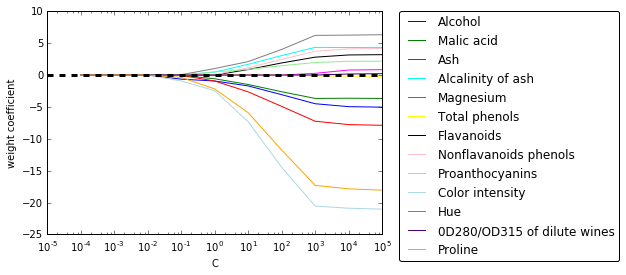

In [30]:
fig = plt.figure()
ax = plt.subplot(111)
colors = ['blue', 'green', 'red', 'cyan',
         'magenta', 'yellow', 'black',
         'pink','lightgreen', 'lightblue',
         'gray', 'indigo', 'orange']
weights, params = [], []
for c in np.arange(-4, 6):
    lr = LogisticRegression(penalty='l1',
                           C=10**c,
                           random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10**c)

weights = np.array(weights)
for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column],
            label=df_wine.columns[column+1],
            color=color)

plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center',
         bbox_to_anchor=(1.38, 1.03),
         ncol=1, fancybox=True)
plt.show()

the plot above provides insight about the behavior of L1 regularization. All features weights willbe zero if we penalize the model with a strong regularization paramerter (C < 0.1); C is the inverse of the regularization parameter *lambda*

## sequential feature selection algorithms

Here we'll use our implementation of the **Sequential Backwards Selection** algorithm for feature selection to reduce the number of features... this is useful for models that do not support regularization, such as kNN

In [34]:
from sklearn.neighbors import KNeighborsClassifier
from sbs import SBS
import matplotlib.pyplot as plt
knn = KNeighborsClassifier(n_neighbors=2)
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

since our implementation saves the scores achieved at each stage of the selection process, whe can plot to see how the score improved with different number of features

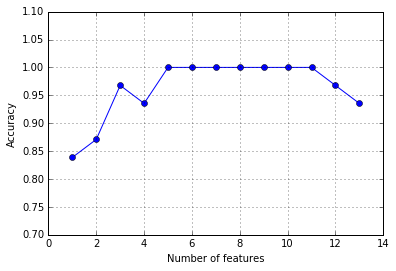

In [35]:
k_feat = [len(k) for k in sbs.subsets_]
plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.1])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.show()

With number of features from 5 to 9, we reached maximum accuracy... let's which five features those were

In [36]:
# indices for the feature subset at the 8th position
k5 = list(sbs.subsets_[8])
print(df_wine.columns[1:][k5])

Index(['Alcohol', 'Malic acid', 'Alcalinity of ash', 'Hue', 'Proline'], dtype='object')


evaluating kNN model performance with the original test set

In [38]:
knn.fit(X_train_std, y_train)
print('Training accuracy:', knn.score(X_train_std, y_train))
print('Test accuracy:', knn.score(X_test_std, y_test))

Training accuracy: 0.983870967742
Test accuracy: 0.944444444444


the accuracy for the test set (94%) was slightly lower than that of the training set (98%) which is a sign of a slight degree of overfitting

now let's compare with the accuracy using only the selected 5-features

In [39]:
knn.fit(X_train_std[:, k5], y_train)
print('Training accuracy:',
     knn.score(X_train_std[:, k5], y_train))
print('Testi accuracy:',
     knn.score(X_test_std[:, k5], y_test))

Training accuracy: 0.959677419355
Testi accuracy: 0.962962962963


with fewer than half of the original features, the accuracy on the testing sample improved by almost 2%, also the gap between the test and training accuracy reduced, a sign that we reduced overfitting

## assessing feature importance with randome forests

In [41]:
from sklearn.ensemble import RandomForestClassifier
feat_labels = df_wine.columns[1:]
forest = RandomForestClassifier(n_estimators=10000,
                               random_state=0,
                               n_jobs=-1)
# with tree_based models data does not have to be standardized
forest.fit(X_train, y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                           feat_labels[f],
                           importances[indices[f]]))


 1) Alcohol                        0.182483
 2) Malic acid                     0.158610
 3) Ash                            0.150948
 4) Alcalinity of ash              0.131987
 5) Magnesium                      0.106589
 6) Total phenols                  0.078243
 7) Flavanoids                     0.060718
 8) Nonflavanoids phenols          0.032033
 9) Proanthocyanins                0.025400
10) Color intensity                0.022351
11) Hue                            0.022078
12) 0D280/OD315 of dilute wines    0.014645
13) Proline                        0.013916


the above code trains a random forest with 10k trees on the dataset... from it we can find out the rank of each feature and its relative importance

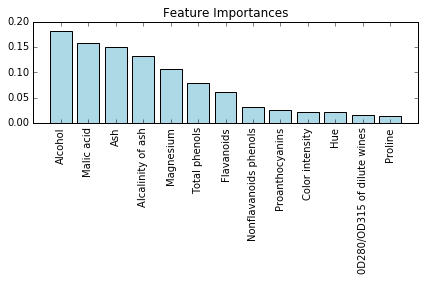

In [43]:
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]),
       importances[indices],
       color='lightblue',
       align='center')
plt.xticks(range(X_train.shape[1]),
          feat_labels, rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

note that the importances are normalized so that they sum up to 1

Interestingly, the 3 tope ranked features are also part of the 5 features selected by our SBS algorithm.

sklearn also implements a `transform` method to select features based on a specified threshold after fitting, useful as an intermediate step in an sklearn pipeline. (**it appears support to use estimators as feature selectors is deprecated, use `SelectFromModel`**)

In [45]:
# this will reduce the dataset to the 3 most important features
# Alcohol, Malic acid, Ash
X_selected = forest.transform(X_train, threshold=0.15)
X_selected.shape

/home/ubuntu/workspace/venv/lib/python3.4/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


(124, 3)